# PHYS 3317 -- Using Finite Differences to find Eigenstates of 1D single particle Hamiltonians

<font color="red"><em> Lee Swindell</em></font>

Here we will use computational Linear Algebra to solve the time independent Schrodinger Equation

## Constructing the Hamiltonian

In [1]:
%pylab inline

from scipy.sparse import *  # loads the functions to deal with sparse matrices
from showmat import showmat # loads display functions 
# if you get an error message, download showmat.py and put in directory with notebooks

Populating the interactive namespace from numpy and matplotlib


First we make a function which generates the finite difference approximation to the second derivative.  

In [2]:
def SecondDerivMatrix(numpoints,dx,periodic) : 
    """SecondDerivMatrix(numpoints,dx,periodic) returns a sparse matrix
    which represents the second derivative -- using a 3-point derivative.  

    It takes periodic needed arguments:
    numpoints -- an integer which is how many points are in the grid
    dx -- the real space lattice spacing
    periodic -- do we use periodic boundary conditions?

    Setting periodic to "False" will give "hard wall boundaries"
    """
    unitlist=ones(numpoints)  # just a list of 1's whose length is equal to the length of the grid
    if periodic :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2),unitlist/(dx**2),unitlist/(dx**2)),
            (1,-1,0,numpoints-1,1-numpoints)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    else :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2)),
            (1,-1,0)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))

To make this concrete lets generate examples

In [3]:
sm=SecondDerivMatrix(numpoints=9,dx=0.5,periodic=False) #make an example

In [4]:
showmat(sm.todense()) # look at it

-8,4,,,,,,,
4,-8,4,,,,,,
,4,-8,4,,,,,
,,4,-8,4,,,,
,,,4,-8,4,,,
,,,,4,-8,4,,
,,,,,4,-8,4,
,,,,,,4,-8,4
,,,,,,,4,-8


Here is the same thing, but with periodic boundary conditions

In [5]:
sm2=SecondDerivMatrix(numpoints=9,dx=0.5,periodic=True) #make an example

In [6]:
showmat(sm2.todense()) # look at it

-8,4,,,,,,,4
4,-8,4,,,,,,
,4,-8,4,,,,,
,,4,-8,4,,,,
,,,4,-8,4,,,
,,,,4,-8,4,,
,,,,,4,-8,4,
,,,,,,4,-8,4
4,,,,,,,4,-8


Next we make a function which generates the finite difference approximation to the operator V(x).  This is a diagonal matrix:

$$
\left(
\begin{array}{ccccc}
V(x_1)&0&\cdots&&\cr
0&V(x_2)&0&0&\cdots\cr
0&0&V(x_3)&0&\cdots\cr
\vdots\cr
\vdots&&&&V(x_n)
\end{array}
\right)
\left(
\begin{array}{c}
\psi(x_1)\cr
\psi(x_2)\cr
\psi(x_3)\cr
\vdots\cr
\psi(x_n)
\end{array}
\right)=
\left(
\begin{array}{c}
V(x_1)\psi(x_1)\cr
V(x_2)\psi(x_2)\cr
V(x_3)\psi(x_3)\cr
\vdots\cr
V(x_n)\psi(x_n)
\end{array}\right)
$$


For variety, this time instead of taking a list of V's as its argument, I will make it so it takes the function $V(x)$ as its argument

In [2]:
def PotentialMatrix(potentialfunction,minx,maxx,numpoints=None,dx=None):
    """PotentialMatrix(potentialfunction,minx,maxx,periodic,numpoints,dx)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potentialfunction -- a function which when called with x returns V(x)
    minx -- smallest x in grid
    maxx -- largest x in grid
    numpoints -- number of points in grid
    dx -- grid spacing

    Either specify numpoints or dx -- but not both"""
    
    # First we check to see if numpoints and/or dx are specified
    #
    # #If you are new to programming, don't worry too much about
    # #this section -- it is just here to give us the flexibility
    # #to specify the grid either by the number of points or
    # #the spacing.  
    #
    # in the former case we would use linspace(xmin,xmax,numpoints)
    # in the latter case we would use arange(xmin,xmax,dx)
    #
    # It is useful to see this sort of construction, as undoubtedly
    # you will want to throw error messages some time in the future.
    #
    if numpoints==None: #was numpoints specified
        if dx==None: #was dx specified
            # oops -- neither are specified, give error message
            raise Exception("Error: you must specify either numpoints or dx")
        else: # great -- dx is specified, but numpoints is not
            grid = arange(minx,maxx+dx,dx)
    else : # numpoints is specified
        if dx==None: # check to make sure dx is not specified
            grid=linspace(minx,maxx,numpoints)
        else : # both are specified
            if dx*(numpoints-1)==(maxx-minx): # are they consistent?
                grid=linspace(minx,maxx,numpoints) 
            else:
                raise Exception("error: dx and numpoints are not consistent -- please just specify one of them")
    
    # now generate the values of the potential on the grid
    potvals=array([potentialfunction(x) for x in grid])
    
    #now generate matrix
    ln=len(grid)
    return dia_matrix((potvals,0),shape=(ln,ln))
    

Next, we want an example potential matrix -- lets use a harmonic oscillator

In [3]:
def hopot(x):  # this is the V(x) for a harmonic oscillator with omega=1,and m=1
    return (x**2)/2.

In [4]:
pm=PotentialMatrix(potentialfunction=hopot,minx=-2,maxx=2,dx=0.5) #make an example

In [5]:
showmat(pm.todense()) #look at it

2,,,,,,,,
,1.12,,,,,,,
,,0.5,,,,,,
,,,0.12,,,,,
,,,,,,,,
,,,,,0.12,,,
,,,,,,0.5,,
,,,,,,,1.12,
,,,,,,,,2


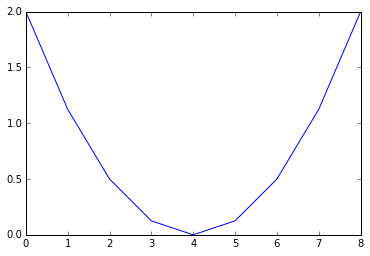

In [11]:
plot(pm.diagonal()) # plot the diagonal

Now lets make a function which generates the Hamiltonian as a matrix

In [12]:
def HamiltonianMatrix(potentialfunction,minx,maxx,numpoints,periodic,hbar=1,mass=1):
    """HamiltonianMatrix(potentialfunction,minx,maxx,numpoints,hbar=1,mass=1)
    generates a finite difference approximation to the hamiltonian operator H
    for the case of a single particle in a potential V(x)

    It is called by the following required arguments:
    potentialfunction -- a function which when called with x returns V(x)
    minx -- smallest x in grid
    maxx -- largest x in grid
    numpoints -- number of points in grid
    
    It also has two optional arguments, which are assumed to be equal to unity if they
    are not specified
    hbar -- Planck's constant divided by 2 pi
    mass -- the particle mass
    """
    dx=1.*(maxx-minx)/(numpoints-1) # calculate grid spacing
    kin=-(0.5*hbar**2/mass)*SecondDerivMatrix(numpoints=numpoints,dx=dx,periodic=periodic) # calculate kinetic energy operator
    pot=PotentialMatrix(potentialfunction=potentialfunction,minx=minx,maxx=maxx,numpoints=numpoints) #calculate potential energy operator
    return kin+pot

Continuing with the harmonic oscilator example

In [13]:
ham1=HamiltonianMatrix(potentialfunction=hopot,minx=-10,maxx=10,numpoints=1000,periodic=True)

In [14]:
ham1.shape # how big is the matrix?

(1000, 1000)

Lets look at the first few entries

In [15]:
showmat(ham1[:10,:10].todense())

$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,,,,
$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,,,
,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,,
,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,
,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,
,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,
,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,
,,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,
,,,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$
,,,,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$


Lets look at the last few entries of the first line

In [16]:
showmat(ham1[:10,-10:].todense())

,,,,,,,,,$-1.2\cdot10^{3}$
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


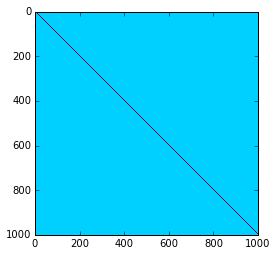

In [17]:
imshow(ham1.todense()) # interpret the entries in the hamiltonian as pixels in an image

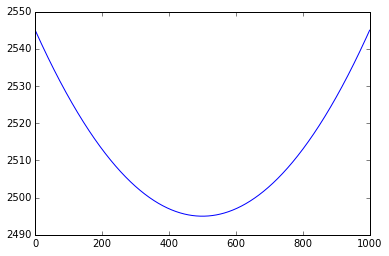

In [18]:
plot(ham1.diagonal()) #plot the diagonal

In [19]:
ham1[0,1] # look at the second element on the first line

-1247.50125

## Numerically finding the eigenvalues and eigenvectors

In [20]:
from scipy.sparse.linalg import eigsh  # load the function which calculates eigenvectors of hermitian matrices

In [21]:
?eigsh

Here is an example of just getting the eigenvalues

In [22]:
eigsh(ham1, # matrix to diagonalize
 k=10, # find 10 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([ 0.49998747,  1.49993737,  2.49983716,  3.49968685,  4.49948641,
        5.49923587,  6.4989352 ,  7.4985844 ,  8.49818348,  9.49773243])

Take a moment to marvel in this -- you just diagonalized a 1000x1000 matrix.

Here is how we get both eigenvalues and eigenvectors

In [23]:
energies,wavefunctions=eigsh(ham1,k=10, sigma=0,  return_eigenvectors=True)

Lets now plot the lowest few eigenvectors -- note these wavefunctions are not normalized.

In [24]:
grid=linspace(-10,10,1000)

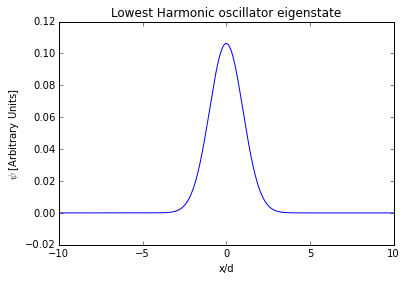

In [25]:
plot(grid,-wavefunctions[:,0])
title("Lowest Harmonic oscillator eigenstate")
xlabel("x/d")
ylabel("$\psi$ [Arbitrary Units]")

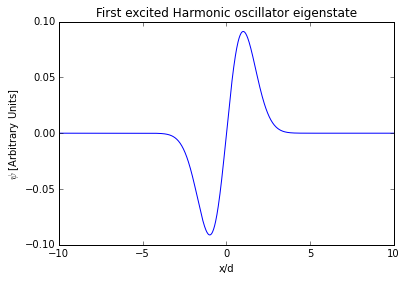

In [26]:
plot(grid,-wavefunctions[:,1])
title("First excited Harmonic oscillator eigenstate")
xlabel("x/d")
ylabel("$\psi$ [Arbitrary Units]")

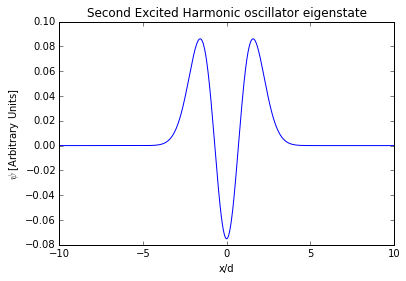

In [27]:
plot(grid,-wavefunctions[:,2])
title("Second Excited Harmonic oscillator eigenstate")
xlabel("x/d")
ylabel("$\psi$ [Arbitrary Units]")

Lets now make a classic picture which you might have seen in a textbook.  We will plot each of the wavefunctions, offsetting them by the energy

In [28]:
potvalues= 0.5*grid**2

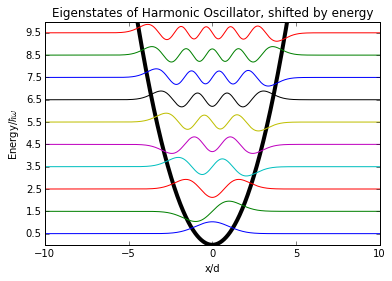

In [29]:
plot(grid,potvalues,linewidth=4,color=(0,0,0)) #plot the parabola representing the harmonic potential 
ylim(0,10) # rescale the y-axis
xlabel("x/d") # label the x-axis
ylabel("Energy/$\hbar\omega$") # label the y-axis
title("Eigenstates of Harmonic Oscillator, shifted by energy") # set title
yticks(arange(0.5,10,1)) # set the ticks on the y-axis to line up with the energies of the states
for index,en in enumerate(energies): # loop over the eigen-energies
    plot(grid,en-5*wavefunctions[:,index]) # plot each wavefunction, scaling and offsetting

### Problems

1) Numerically calculate the lowest 5 eigen-energies of an infinite square well of length 1, in units where hbar=m=1.  

Note: you don't need to use HamiltonianMatrix -- just use SecondDerivMatrix with hard wall boundaries.  Plot the eigenstates. (The plot doesn't need to be as fancy as the last one we did for the Harmonic Oscillator -- just separate graphs are fine.  Label the axes.  If you want to make the fancy graphs, that is also fine.)

In [117]:
inf_well=-.5*SecondDerivMatrix(100,.01,False)

In [118]:
eigsh(inf_well, # matrix to diagonalize
 k=5, # find 5 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([   4.83717708,   19.34402866,   43.50652031,   77.30127637,
        120.69560259])

In [119]:
energies,wavefunctions=eigsh(inf_well,k=5, sigma=0,  return_eigenvectors=True)

In [120]:
grid1=linspace(0,1,100)

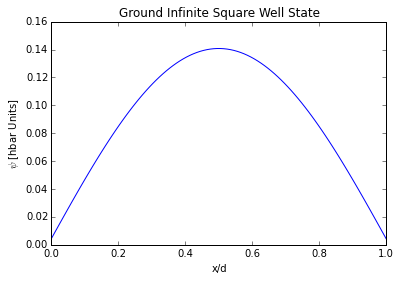

In [121]:
plot(grid1,-wavefunctions[:,0])
title("Ground Infinite Square Well State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

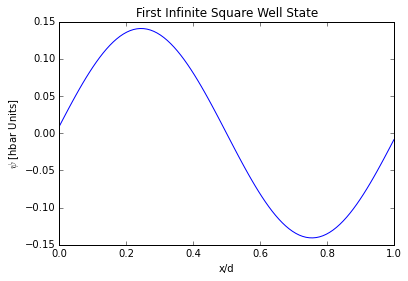

In [122]:
plot(grid1,-wavefunctions[:,1])
title("First Infinite Square Well State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

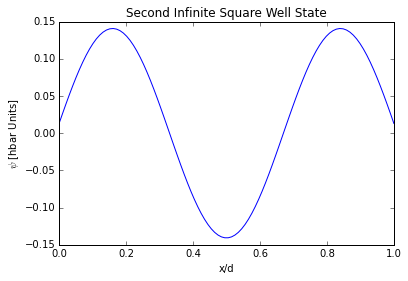

In [123]:
plot(grid1,-wavefunctions[:,2])
title("Second Infinite Square Well State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

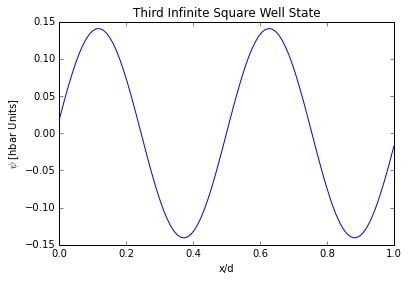

In [124]:
plot(grid1,-wavefunctions[:,3])
title("Third Infinite Square Well State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

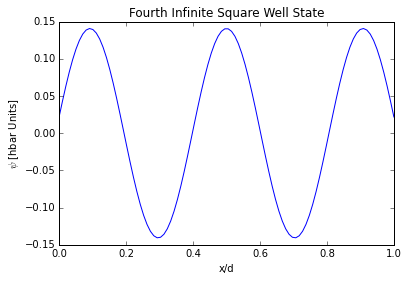

In [125]:
plot(grid1,-wavefunctions[:,4])
title("Fourth Infinite Square Well State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

2) Calculate the lowest 10 eigen-energies of a particle in a double-well potential $V(x)=0.5*(x^2-4)^2$.  Use units where $\hbar=m=1$.  Is there a separation of scales?  Plot the lowest 4 eigenstates.

There is a seperation of scales. Below the potential barrier in the middle, the particle acts like it's in either one well or the other. once it has more energy than the potential barrier in the middle, it acts more like it's in a box

In [52]:
def double_well_pot(x):
    return .5*(x**2-4)**2

In [53]:
double_well_ham=HamiltonianMatrix(potentialfunction=double_well_pot,minx=-10,maxx=10,numpoints=1000,periodic=True)
eigsh(double_well_ham, # matrix to diagonalize
 k=10, # find 10 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([  1.9316541 ,   1.93241285,   5.43604847,   5.49381635,
         7.93309184,   8.708062  ,  10.45328908,  12.19521037,
        14.18341336,  16.32606434])

In [65]:
energies,wavefunctions=eigsh(double_well_ham,k=4, sigma=0,  return_eigenvectors=True)
grid2=linspace(-10,10,1000)

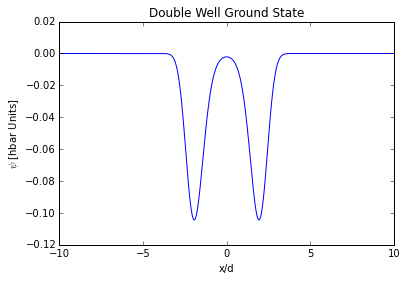

In [67]:
plot(grid2,-wavefunctions[:,0])
title("Double Well Ground State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

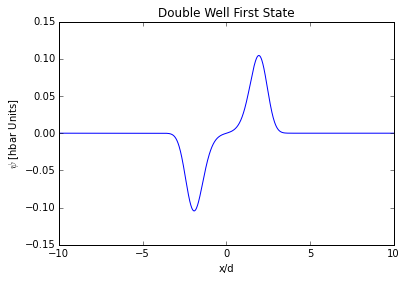

In [68]:
plot(grid2,-wavefunctions[:,1])
title("Double Well First State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

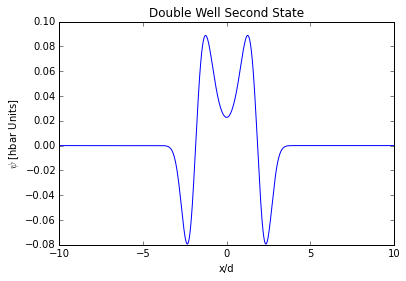

In [69]:
plot(grid2,-wavefunctions[:,2])
title("Double Well Second State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

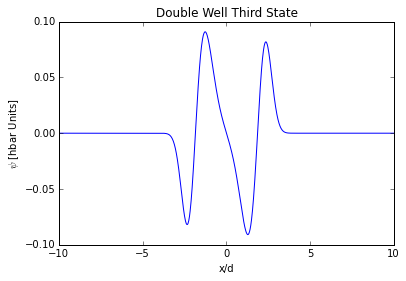

In [70]:
plot(grid2,-wavefunctions[:,3])
title("Double Well Third State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

3) Repeat with $V(x)=0.1∗(x^2−4)^2$.  

In [83]:
def double_well_pot2(x):
    return .1*(x**2-4)**2

In [104]:
double_well_ham2=HamiltonianMatrix(potentialfunction=double_well_pot2,minx=-10,maxx=10,numpoints=1000,periodic=True)
eigsh(double_well_ham, # matrix to diagonalize
 k=10, # find 10 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([  1.9316541 ,   1.93241285,   5.43604847,   5.49381635,
         7.93309184,   8.708062  ,  10.45328908,  12.19521037,
        14.18341336,  16.32606434])

In [105]:
energies,wavefunctions=eigsh(double_well_ham2,k=4, sigma=0,  return_eigenvectors=True)
grid2=linspace(-10,10,1000)

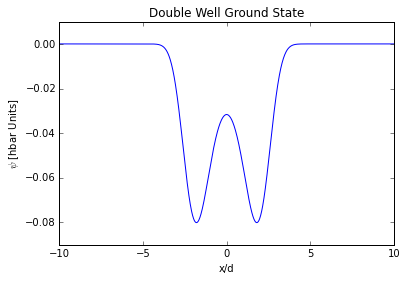

In [106]:
plot(grid2,-wavefunctions[:,0])
title("Double Well Ground State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

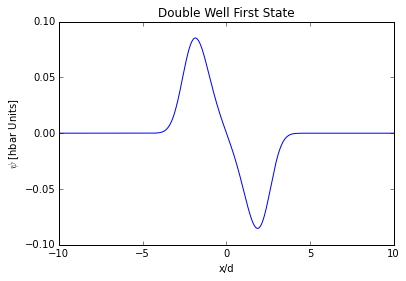

In [107]:
plot(grid2,-wavefunctions[:,1])
title("Double Well First State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

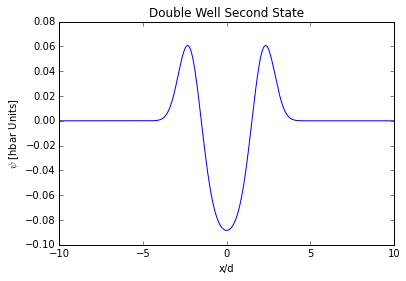

In [108]:
plot(grid2,-wavefunctions[:,2])
title("Double Well Second State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

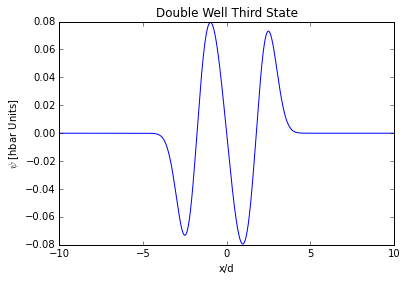

In [109]:
plot(grid2,-wavefunctions[:,3])
title("Double Well Third State")
xlabel("x/d")
ylabel("$\psi$ [hbar Units]")

3) Numerically calculate the lowest 5 energy eigenvalues of a free particle confined in a box of length 1 with periodic boundary conditions.

In [115]:
inf_well2=-.5*SecondDerivMatrix(100,.01,True)
eigsh(inf_well2, # matrix to diagonalize
 k=5, # find 5 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([  4.54747351e-14,   1.96890863e+01,   1.97609980e+01,
         7.84727294e+01,   7.94071653e+01])

<u>Give answer (program) here -- add more cells as necessary</u>

4) In this case of a periodic box, are the eigenstates unique?  Why or why not?  

Yes, the eigenstates are unique. each degenerate eigen-energy has 2 unique eigenstates with + or - n. they are unique since they can't be related by a phase factor